# Chapter 4 - データ前処理 : よりよいトレーニングセットの構築

データの品質と有益な情報の量は, 機械学習アルゴリズムの学習効率を決定するうえで重要.<br />
→ データセットを精査し, 前処理を行うのがよい.

この章では, 以下について勉強する:

- データセットにおける欠陥値の削除と補完
- 機械学習のアルゴリズムに合わせたカテゴリデータの整形
- モデルの構築に適した特徴量の選択

In [1]:
from IPython.display import Image
%matplotlib inline

In [2]:
# Added version check for recent scikit-learn 0.18 checks
from distutils.version import LooseVersion as Version
from sklearn import __version__ as sklearn_version

## 欠測データへの対処

- **欠損値** (missing value): データを収集する過程で誤りがあったり, 不適切な測定があったり, アンケート調査で空欄になっていたりするなどの理由で, 値が存在しないもの.
    - データテーブルの空欄, `NaN` などのプレースホルダ文字列.
    - 欠損値の対処をしておかないと, 計算できなかったり, 予期せぬ結果を生み出したりする.

単純なサンプルデータを見てみる.

In [3]:
import pandas as pd
from io import StringIO

csv_data = '''A,B,C,D
1.0,2.0,3.0,4.0
5.0,6.0,,8.0
10.0,11.0,12.0,'''

# If you are using Python 2.7, you need
# to convert the string to unicode:
# csv_data = unicode(csv_data)

df = pd.read_csv(StringIO(csv_data))
df

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


欠損しているセルが `NaN` に置きかわっている.

`DataFrame` オブジェクトが大きい場合は, `NaN` がどこにあるか探すのが大変だが, 次のようにすると列ごとに欠損値の個数が計算できる:

In [4]:
df.isnull().sum()

A    0
B    0
C    1
D    1
dtype: int64

なお, `DataFrame` オブジェクトは, `values` 属性でNumPyの配列に変換できる:

In [5]:
print(type(df))
print(type(df.values))

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>


### 欠損値をもつサンプル / 特徴量を取り除く

欠損値があるなら, 該当する特徴量 (列)やサンプル (行)をなかったことにすればよい.

`dropna` メソッドで欠損値を含む行を削除できる (デフォルト値が `axis = 0` で行を消すようになっている).

In [6]:
df.dropna()

,A,B,C,D
0,1.0,2.0,3.0,4.0


`axis` 引数を `1` に設定すれば, `NaN` を含む行が一つでもある列を削除できる.

In [7]:
df.dropna(axis=1)

,A,B
0,1.0,2.0
1,5.0,6.0
2,10.0,11.0


`dropna` メソッドにはほかにも有用な引数がいろいろある:

In [8]:
# only drop rows where all columns are NaN
df.dropna(how='all')  

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [9]:
# drop rows that have not at least 4 non-NaN values
df.dropna(thresh=4)

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [10]:
# only drop rows where NaN appear in specific columns (here: 'C')
df.dropna(subset=['C'])

,A,B,C,D
0,1.0,2.0,3.0,4.0
2,10.0,11.0,12.0,NaN


欠損データの削除について:

- 利点:
    - 楽.
- 欠点:
    - サンプルを削除しすぎた場合は, 解析の信頼性が失われる可能性がある.
    - 特徴量の列を削除しすぎた場合は, 分類器がクラスを識別するのに必要な, 有益な情報が失われる可能性がある.
    
貴重なデータを失うのはよろしくない.

### 補間法

- **補間法** (interpolation technique): データセットの他のトレーニングサンプルから欠損値を推測する方法. 欠損値の対処によく利用される.
    - **平均値補間** (mean imputation): 欠測値を, 特徴量の列全体の平均値と置き換える.

In [11]:
from sklearn.preprocessing import Imputer

imr = Imputer(missing_values='NaN', strategy='mean', axis=0)
imr = imr.fit(df)
imputed_data = imr.transform(df.values)
imputed_data

array([[  1. ,   2. ,   3. ,   4. ],
       [  5. ,   6. ,   7.5,   8. ],
       [ 10. ,  11. ,  12. ,   6. ]])

In [12]:
df.values # for comparison

array([[  1.,   2.,   3.,   4.],
       [  5.,   6.,  nan,   8.],
       [ 10.,  11.,  12.,  nan]])

行の値を使って補間したり, 平均値の代わりに中央値や最頻値で補間することもできる.

## カテゴリデータの処理

- データの種類:
    - 数値データ:
        - 比例尺度: 値の大小関係, 値の差の大きさ, 比に意味がある. 値0が絶対的な意味を持つ.
            - 利用できる統計量: 度数, 最頻値, 中央値, 四分位数, 平均, 標準偏差, 変動係数, 幾何平均.
            - ex) 身長, 絶対温度.
        - 間隔尺度: 値の大小関係, 値の差の大きさに意味がある. 値0が相対的な意味しか持たない.
            - 利用できる統計量: 度数, 最頻値, 中央値, 四分位数, 平均, 標準偏差.
            - ex) 摂氏 / 華氏温度.
    - カテゴリデータ:
        - 順序尺度: 値の大小関係に意味がある. 順序が入っているため, 比較可能.
            - 利用できる統計量: 度数, 最頻値, 中央値, 四分位数.
            - ex) 服のサイズ (XL > L > M > S > XS), 5段階の成績.
        - 名義尺度: 同じ値かどうかのみ意味がある.
            - 利用できる統計量: 度数, 最頻値.
            - ex) 色.

次のようなデータを扱ってみる.

In [13]:
import pandas as pd

df = pd.DataFrame([['green', 'M', 10.1, 'class1'],
                   ['red', 'L', 13.5, 'class2'],
                   ['blue', 'XL', 15.3, 'class1']])

df.columns = ['color', 'size', 'price', 'classlabel']
df

,color,size,price,classlabel
0,green,M,10.1,class1
1,red,L,13.5,class2
2,blue,XL,15.3,class1


このデータは, 名義尺度 (`color`), 順序尺度 (`size`), 比例尺度 (`price`) の列が含まれている.
クラスラベルは最後の列に格納される (クラスラベルに順序の情報を利用しない).

### 順序尺度のマッピング

- 学習アルゴリズムに順序尺度を正しく学習させるには, 文字列を整数に変換する必要がある.
    - 整数などへの変換写像は, 明示的に定義する必要あり.
    - 逆写像も用意しておくことで, 後から数値から文字列表現を再生することが可能.

例えば, 上の例では次のようにする:

In [14]:
size_mapping = {'XL': 3,
                'L': 2,
                'M': 1}

df['size'] = df['size'].map(size_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class1
1,red,2,13.5,class2
2,blue,3,15.3,class1


逆写像は次のように定めておく:

In [15]:
inv_size_mapping = {v: k for k, v in size_mapping.items()}
df['size'].map(inv_size_mapping)

0     M
1     L
2    XL
Name: size, dtype: object

### クラスラベルのエンコーディング

クラスラベルも, 事前に整数に変換しておくのがよい:

In [16]:
import numpy as np

class_mapping = {label: idx for idx, label in enumerate(np.unique(df['classlabel']))}
class_mapping

{'class1': 0, 'class2': 1}

今生成したマッピングディクショナリを使って, クラスラベルを整数に変換:

In [17]:
df['classlabel'] = df['classlabel'].map(class_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,0
1,red,2,13.5,1
2,blue,3,15.3,0


元に戻す場合は次のようにする:

In [18]:
inv_class_mapping = {v: k for k, v in class_mapping.items()}
df['classlabel'] = df['classlabel'].map(inv_class_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class1
1,red,2,13.5,class2
2,blue,3,15.3,class1


次のようなものをつかってもいいかも:

In [19]:
from sklearn.preprocessing import LabelEncoder

class_le = LabelEncoder()
y = class_le.fit_transform(df['classlabel'].values)
y

array([0, 1, 0], dtype=int64)

In [20]:
class_le.inverse_transform(y)

array(['class1', 'class2', 'class1'], dtype=object)

### 名義尺度での one-hot エンコーディング

- 名義尺度でも, 上と同様にできる?

In [21]:
X = df[['color', 'size', 'price']].values

color_le = LabelEncoder()
X[:, 0] = color_le.fit_transform(X[:, 0])
X

array([[1, 1, 10.1],
       [2, 2, 13.5],
       [0, 3, 15.3]], dtype=object)

→ `blue` が0, `green` が1, `red` が2と, 本来ないはずの順序が入ってしまう!

**one-hot エンコーディング** を用いてこの問題を回避する.

- 名義尺度の列の一意な値ごとに **ダミー特徴量** (dummy feature) を新しく作成する.
    - 色については, `blue, green, red` の三つがあるので, 色ごとにダミー特徴量を新しく作り, 例えば青のものなら `blue = 1, green = 0, red = 0` などとすればよい.
    - `scikit-learn.preprocessing` モジュールの `OneHotEncoder` クラスを使用する.

In [22]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(categorical_features=[0])
ohe.fit_transform(X).toarray()

array([[  0. ,   1. ,   0. ,   1. ,  10.1],
       [  0. ,   0. ,   1. ,   2. ,  13.5],
       [  1. ,   0. ,   0. ,   3. ,  15.3]])

`categorical_features` で指定された位置の列がone-hotエンコーディングされ, ダミー特徴量の列 (左側3列) が新たに作られた.
見てわかるように, 疎 (i.e., 0が多い)になっている.

pandasの `get_dummies` 関数を使うのも便利:

In [23]:
pd.get_dummies(df[['price', 'color', 'size']])

,price,size,color_blue,color_green,color_red
0,10.1,1,0,1,0
1,13.5,2,0,0,1
2,15.3,3,1,0,0


## データセットの分割

データセットを, トレーニングデータセットとテストデータセットの二つに分割する.
Wineデータセットを用いる.

In [24]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/'
                      'ml/machine-learning-databases/wine/wine.data',
                      header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

print('Class labels', np.unique(df_wine['Class label']))
df_wine.head()

Class labels [1 2 3]


,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


これらのサンプルは, クラス1, 2, 3のいずれか (ブドウの品種に相当)に属する.

データセットをテストデータセットとトレーニングデータに分割するには, scikit-learnの `cross_validation` モジュール内の `train_test_split` 関数を利用するのが便利.

In [25]:
if Version(sklearn_version) < '0.18':
    from sklearn.cross_validation import train_test_split
else:
    from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

ここでは, 全体の30%をテストデータにしている.

テストデータの割合について:

- テストデータにデータを配分することで, 学習アルゴリズムに価値があるかもしれない貴重な情報を間引いていることに注意.
- テストデータセットに割り当てる情報が多くなりすぎないようにしたい.
- 少なすぎても, 汎化誤差の推定の正確性が失われる.<br />
    → トレードオフを探る.
- 実際には, よく利用される比率は, 60:40, 70:30, 80:20のいずれか.
    - データセットが大きい場合は, 90:10, 99:1で分割するのも一般的で, 妥当.
- 性能を最適化するには, モデルのトレーニングと評価を行ってハイパーパラメータを最適化したのち, データセット全体に対して, 得られたハイパーパラメータで分類器をもう一度トレーニングするとよい.

## 特徴量のスケーリング

- **特徴量のスケーリング** (feature scaling)
    - 機械学習と最適化のアルゴリズムの大半は, 特徴量の尺度が同じである場合に遥かにうまく動作する.
- 特徴量の尺度をそろえる方法:
    - **正規化** (normalization): 
        - $[0,1]$ の範囲にスケーリングすること.
        - サンプル $x^{(i)}$ の正規化は, 特徴量の列における最小値, 最大値をそれぞれ $x_{\text{min}}, x_{\text{max}}$ とすると, 正規化された特徴量は
            $$
                x_{\text{norm}}^{(i)} = \frac{x^{(i)} - x_{\text{min}}}{x_{\text{max}} - x_{\text{min}}}
            $$
            と計算できる (min-maxスケーリング).
        - 有界区間の値が必要である場合に有用.
    - **標準化** (standardization): 
        - 平均値が0, 標準偏差が1になるように変換する.
        - 特徴量の列の平均値を $\mu_x$, 対応する標準偏差を $\sigma_x$ とすると, 標準化された特徴量は, 
            $$
                x_{\text{std}}^{(i)} = \frac{x^{(i)} - \mu_x}{\sigma_x}
            $$
            と計算できる.
        - 特徴量の列は正規分布に従うため, 重みを学習しやすくなる.
        - 外れ値に関する有用な情報が維持されるので, 外れ値から受ける影響が少なくなる.
    - 多くの線形モデルが, 重みを0, または0に近い乱数に初期化するため, 標準化のほうが実用的.

正規化は次のようにする:

In [26]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)

標準化は次のように行う:

In [27]:
from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

それぞれの違いは次の表の通り:

In [28]:
ex = pd.DataFrame([0, 1, 2, 3, 4, 5])

# standardize
ex[1] = (ex[0] - ex[0].mean()) / ex[0].std(ddof=0)

# Please note that pandas uses ddof=1 (sample standard deviation) 
# by default, whereas NumPy's std method and the StandardScaler
# uses ddof=0 (population standard deviation)

# normalize
ex[2] = (ex[0] - ex[0].min()) / (ex[0].max() - ex[0].min())
ex.columns = ['input', 'standardized', 'normalized']
ex

,input,standardized,normalized
0,0,-1.46385,0.0
1,1,-0.87831,0.2
2,2,-0.29277,0.4
3,3,0.29277,0.6
4,4,0.87831,0.8
5,5,1.46385,1.0


## 有益な特徴量の選択

- テストデータセットよりも, トレーニングデータセットのほうがモデルのパフォーマンスがよい<br />
    → 過学習の兆候. モデルのバリアンスが高い.
    - 原因: 与えられたトレーニングデータセットに対して, モデルが複雑すぎる.
- 汎化誤差を減らすための一般的な方法:
    - トレーニングデータをもっと集める.
        - 実際問題むずかしい.
    - 正則化を通して, 複雑さにペナルティを科す.
    - パラメータの数が少ない, より単純なモデルを選択する.
    - データの次元を減らす.

### L1正則化

- L2正則化: モデルの複雑さを低減する方法の一つ.
    - モデルの複雑さは, 大きな重みにペナルティを科すことで低減される.
    - ペナルティ項は, 次の通りであった:
        $$
            (\| w \|_2)^2 = \sum_{j=1}^{m} |w_j|^2.
        $$
- **L1正則化**: L2正則化で, ペナルティを次のようにL1ノルムに置き換えたもの:
    $$
        (\| w \|_1)^2 = \sum_{j=1}^{m} |w_j|.
    $$
    - L1正則化で返されるのは, 疎な特徴ベクトル, i.e., ほとんどの特徴量の重みが0になる.<br />
        → 無関係な特徴量の個数が多い高次元のデータセットが, 特に, 無関係な次元の数がサンプルよりも多い場合に有効.
    - どのようにしてスパース性を実現できるかについては, 幾何学的に理解可能 (図は省略).

L1正則化をしてみる.

In [29]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l1', C=0.1)
lr.fit(X_train_std, y_train)
print('Training accuracy:', lr.score(X_train_std, y_train))
print('Test accuracy:', lr.score(X_test_std, y_test))

Training accuracy: 0.983870967742
Test accuracy: 0.981481481481


トレーニングデータも, テストデータも, 正解率が98%であり, モデルが過学習に陥っていないことがわかる.

In [30]:
lr.intercept_

array([-0.3838717 , -0.15808384, -0.700457  ])

切片項は三つの値を返すことがわかる.
一つ目はクラス1 vs. クラス2, 3に適合するモデルの切片.
二つ目はクラス2 vs. クラス1, 3に適合するモデルの切片.
三つ目はクラス3 vs. クラス1, 2に適合するモデルの切片.

In [31]:
lr.coef_

array([[ 0.28021616,  0.        ,  0.        , -0.02803212,  0.        ,
         0.        ,  0.71006703,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.23601741],
       [-0.64398057, -0.06881138, -0.05719982,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.92678926,
         0.06020972,  0.        , -0.37102118],
       [ 0.        ,  0.06154023,  0.        ,  0.        ,  0.        ,
         0.        , -0.63572378,  0.        ,  0.        ,  0.49788223,
        -0.35830322, -0.57165632,  0.        ]])

クラスごとに重みベクトルが一つ含まれている.
これらの重みベクトルはスパースなものになっており, データセット内の無関係かもしれない特徴量に対しても頑健なモデルがトレーニングされていることが確認できる.

正則化パス (i.e., 正則化の強さに対する特徴量の重み係数) をグラフ化してみる.

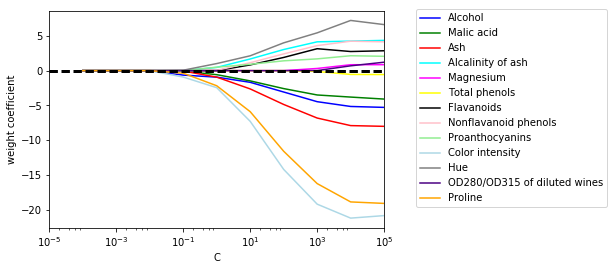

In [32]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.subplot(111)
    
colors = ['blue', 'green', 'red', 'cyan', 
          'magenta', 'yellow', 'black', 
          'pink', 'lightgreen', 'lightblue', 
          'gray', 'indigo', 'orange']

weights, params = [], []
for c in np.arange(-4., 6.):
    lr = LogisticRegression(penalty='l1', C=10.**c, random_state=0)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10.**c)

weights = np.array(weights)

for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, weights[:, column],
             label=df_wine.columns[column + 1],
             color=color)
plt.axhline(0, color='black', linestyle='--', linewidth=3)
plt.xlim([10**(-5), 10**5])
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.xscale('log')
plt.legend(loc='upper left')
ax.legend(loc='upper center', 
          bbox_to_anchor=(1.38, 1.03),
          ncol=1, fancybox=True)
# plt.savefig('./figures/l1_path.png', dpi=300)
plt.show()

$C$ を小さくしていく, i.e., ペナルティの強さを高めていくと, 特徴量の重みはすべて0になる.

### 逐次特徴選択アルゴリズム

- 特徴選択による **次元削減**: モデルの複雑さを低減し, 過学習を回避する方法の一つ.
    - 正則化されていないモデルに役立つ.
- 次元削減法の分類:
    - **特徴選択** (feature selection)
        - 元の特徴量の一部を選択.
        - 問題に最も関係のある特徴量の部分集合を自動的に選択することで, 計算効率を改善する.
        - 無関係の特徴量やノイズを取り除くことで, モデルの汎化誤差を削減する.
            - 正則化をサポートしていないアルゴリズムに役に立つことがある.
    - **特徴抽出** (feature extraction)
        - 新しい特徴部分空間を生成するために, 特徴量の集合から情報を抽出する.

ここでは, 特徴選択アルゴリズムを取り上げる.

- 特徴選択アルゴリズムの分類:
    - **フィルタ法** (filter method): 学習を伴わずに特徴量の重要度を測定し, 有効な特徴量を選択する.
        - 情報利得, Gini係数などの指標を用いるのが代表的.
        - 計算負荷はラッパー法に比べると小さいが, 精度は低い.
    - **ラッパー法** (wrapper method): 学習を行いながら, 重要な特徴量を選択する.
        - この節で行う, 逐次後退選択はラッパー法.
    - **埋め込み法** (embedded method): 学習アルゴリズムに特徴量選択も埋め込まれている.
        - LASSOなど.

- **貪欲探索** (greedy search): 組合せ探索問題の各段階で局所的に最適な選択が行われるアルゴリズム.
    - 通常は準最適解が得られる.
    - 単純で, 計算効率良く解を求められる.
    - cf.) しらみつぶし探索法 (exhaustive search algorithms): 最適解は得られるが, 計算量の観点から実行可能でない.

- 逐次特徴選択アルゴリズム: 貪欲探索 (greedy search) アルゴリズムの一種.
    - **逐次後退代入** (Sequential Backward Selection: SBS):
        - もともとの特徴空間の次元 $d$ から, $k$ 次元の特徴部分空間が得られるまで減らす.
        - 新しい特徴部分空間に目的の個数の特徴量が含まれるまで, 特徴量全体から特徴量を逐次的に削除していく.
        - 各段階で削除する特徴量: 各段階で性能の低下が最も少ない特徴量.
            - $J(X_k \setminus \{ x \})$ を $X_k$ から特徴量 $x$ を削除した後の分類器の性能から削除する前の分類器の性能を引いた値とすると,き これを最大化する $x^{-}$ を削除する.
        - 分類器の性能の低下を最小限に抑えたうえで計算効率を改善する.
            - モデルが過学習に陥っている場合に, SBSを適用することでモデルの予測性能を改善できることがある.
        - $X_k \triangleq \{ x ~ | ~ x: \text{特徴量} \}, ~~ |X_k| = k$ とする. もともとの特徴空間は $X_d$.
        - アルゴリズムの挙動:
            1. アルゴリズムを $k = d$ で初期化 ($d = \dim X_d$).
            2. $J(X_k \setminus \{ x \})$ を最大化する $x^{-}$ を見つける:
                $$
                    x^{-} := \mathop{argmax}_{x \in X_k} J(X_k \setminus \{ x \}).
                $$
            3. 特徴量の集合から, $x^{-}$ を削除する:
                $$
                    X_{k-1} := X_k \setminus x^{-}; ~~ k := k-1.
                $$
            4. $k$ が目的とする特徴量の個数 $p$ と等しくなれば終了. そうでなければStep 2に戻る.

逐次後退代入を実装してみる.

In [33]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
if Version(sklearn_version) < '0.18':
    from sklearn.cross_validation import train_test_split
else:
    from sklearn.model_selection import train_test_split

class SBS():
    def __init__(self, estimator, k_features, scoring = accuracy_score, test_size=0.25, random_state = 1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = self.test_size, random_state = self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
            
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

k-NN分類器でSBSの効果を確認する.
特徴量の数ごとに, k-NN分類器の正解率を可視化してみる.

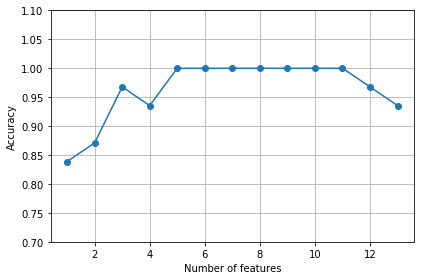

In [34]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=2)

# selecting features
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)

# plotting performance of feature subsets
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.1])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
# plt.savefig('./sbs.png', dpi=300)
plt.show()

特徴量の数を減らしていくと, 次元の呪いが減少したために検証データセットに対するk-NN分類器の正解率が改善されている.
特徴量の数が4以下になると正解率が下がってしまっているので, 特徴量を減らしすぎているようである.

性能を100%にした五つの特徴量は何だったのか?

In [35]:
k5 = list(sbs.subsets_[8])
print(df_wine.columns[1:][k5])

Index(['Alcohol', 'Malic acid', 'Alcalinity of ash', 'Hue', 'Proline'], dtype='object')


なるほどって感じ.

元のテストデータセットでk-NN分類器の評価をしてみる.
まず, 特徴量すべてを使うと, どうなるか?

In [36]:
knn.fit(X_train_std, y_train)
print('Training accuracy:', knn.score(X_train_std, y_train))
print('Test accuracy:', knn.score(X_test_std, y_test))

Training accuracy: 0.983870967742
Test accuracy: 0.944444444444


トレーニングデータセットでは98.4%程度の正解率.
ただし, テストデータセットでは94.4%程度の正解率で, トレーニングデータセットの正解率よりもわずかに低く, 若干過学習気味.

上の五つの特徴量を使ってk-NNの性能を調べてみる.

In [37]:
knn.fit(X_train_std[:, k5], y_train)
print('Training accuracy:', knn.score(X_train_std[:, k5], y_train))
print('Test accuracy:', knn.score(X_test_std[:, k5], y_test))

Training accuracy: 0.959677419355
Test accuracy: 0.962962962963


テストデータセットに対する予測精度が2%程改善していてめでたい感じ.
テストデータセットとトレーニングデータセットの正解率の差も減少して, 過学習が軽減されていることも確認できた.

## ランダムフォレストで特徴量の重要度を見る

ランダムフォレストを利用すれば, データが線形分離可能かどうかに前提を設けなくても, フォレスト内のすべての決定木から計算された不純度の平均的な減少量として特徴量の重要度を測定できる.

実際にやってみた.

 1) Color intensity                0.182483
 2) Proline                        0.158610
 3) Flavanoids                     0.150948
 4) OD280/OD315 of diluted wines   0.131987
 5) Alcohol                        0.106589
 6) Hue                            0.078243
 7) Total phenols                  0.060718
 8) Alcalinity of ash              0.032033
 9) Malic acid                     0.025400
10) Proanthocyanins                0.022351
11) Magnesium                      0.022078
12) Nonflavanoid phenols           0.014645
13) Ash                            0.013916


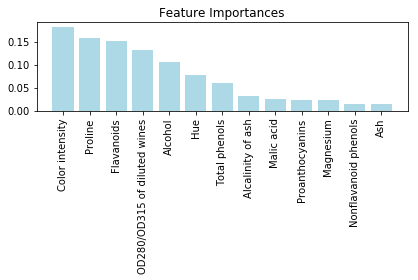

In [38]:
from sklearn.ensemble import RandomForestClassifier

feat_labels = df_wine.columns[1:]

forest = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)

forest.fit(X_train, y_train)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))

plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), importances[indices], color='lightblue', align='center')

plt.xticks(range(X_train.shape[1]), feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
#plt.savefig('./random_forest.png', dpi=300)
plt.show()

特徴量の重要度の合計は1になるように正規化されている.

ワインの色の強さが重要っぽいことが分かった.

**意味解釈可能性に関する注意**:<br />
二つ以上の特徴量の相関が高い場合, 一つの特徴量のランクは非常に高くても, 残りの重要度はランクに十分に反映されないかもしれない.

なお, モデルを適合した後に, ユーザが指定した閾値以上の重要度の特徴量を選択することもできる:

In [39]:
if Version(sklearn_version) < '0.18':
    X_selected = forest.transform(X_train, threshold=0.15)
else:
    from sklearn.feature_selection import SelectFromModel
    sfm = SelectFromModel(forest, threshold=0.15, prefit=True)
    X_selected = sfm.transform(X_train)

X_selected.shape

(124, 3)

三つの特徴量がとれた.
中身を見てみる.

In [40]:
for f in range(X_selected.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

 1) Color intensity                0.182483
 2) Proline                        0.158610
 3) Flavanoids                     0.150948


なるほどなぁ.